In [1]:
import torch
from torchvision import transforms
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set cuDNN to be deterministic for reproducibility and to avoid internal errors
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

cuda


In [3]:
from datasets import load_dataset
ds = load_dataset("nikolkoo/SatelliteSegmentation", split ="train")
ds = ds.filter(lambda x: x["image"] is not None)
ds.save_to_disk("nikokoo")


Saving the dataset (0/1 shards):   0%|          | 0/790 [00:00<?, ? examples/s]

In [4]:
ds.set_format(type="numpy", columns=["image", "mask"])


In [5]:
def augment(data, transform=None):
    img = data["image"]  
    mask = data["mask"]

    if transform is not None:
        augmented = transform(image=img, mask=mask)
        img, mask = augmented["image"], augmented["mask"]

      # Torch Tensor
    img = ToTensorV2()(image=img)["image"]       # [C,H,W], float
    mask = torch.from_numpy(mask)                # [H,W], long

    data["image"] = img
    data["mask"]  = mask
    
    data["mask"] = data["mask"].to(device) / 10
    data["mask"] = data["mask"].long()
    data["image"] = data["image"].to(device) / 255.0
    return data


In [6]:
# define model for Amazondataset
model_landcover = smp.PAN(
    encoder_name = 'resnet34',
    decoder_attention_type="scse",
    encoder_weights = 'imagenet',
    in_channels = 3,
    classes = 11,
    activation=None
    ).to(device)

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_landcover.parameters(), lr=3e-4)

In [8]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # evtl. weitere: A.ShiftScaleRotate, A.RandomCrop
], additional_targets={"mask": "mask"})


In [9]:
tmp = ds.train_test_split(test_size=0.3, seed=42)
train_ds = tmp["train"].map(lambda x:augment(x, transform=train_transform))

tmp2 = tmp["test"].train_test_split(test_size=0.5, seed=42)
val_ds  = tmp2["train"].map(lambda x:augment(x, transform=None))
test_ds = tmp2["test"].map(lambda x:augment(x, transform=None))
print(test_ds["image"][0].shape)

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

/home/lck/Schreibtisch/dev/myvenv/lib/python3.13/site-packages/albumentations/pytorch/transforms.py:86: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(img.transpose(2, 0, 1))
/home/lck/Schreibtisch/dev/myvenv/lib/python3.13/site-packages/datasets/features/image.py:371: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

(3, 256, 256)


In [10]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)


In [11]:
def plot_metrics(metrics):
    """
    Plot training and validation metrics to evaluate model performance.

    Args:
        metrics (dict): Dictionary containing training and validation metrics
                       collected during training.

    Plots:
        - Training and Validation Loss over epochs
        - Validation IoU and Dice over epochs
        - Validation Precision, Recall, and Accuracy over epochs
    """
    import matplotlib.pyplot as plt

    # Calculate additional metrics from tp, fp, tn, fn
    tp = metrics['val']['tp_per_epoch']
    fp = metrics['val']['fp_per_epoch']
    tn = metrics['val']['tn_per_epoch']
    fn = metrics['val']['fn_per_epoch']

    # Precision = TP / (TP + FP)
    precision = [t / (t + f + 1e-7) for t, f in zip(tp, fp)]
    # Recall = TP / (TP + FN)
    recall = [t / (t + f + 1e-7) for t, f in zip(tp, fn)]
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = [(t + n) / (t + n + f + g + 1e-7) for t, n, f, g in zip(tp, tn, fp, fn)]

    epochs = list(range(1, len(metrics['train']['avg_loss_per_epoch']) + 1))

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Training Metrics', fontsize=16, fontweight='bold')

    # Subplot 1: Loss
    axes[0, 0].plot(epochs, metrics['train']['avg_loss_per_epoch'], label='Train Loss', color='blue', linewidth=2, marker='o')
    axes[0, 0].plot(epochs, metrics['val']['avg_loss_per_epoch'], label='Val Loss', color='red', linewidth=2, marker='s')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Subplot 2: IoU
    axes[0, 1].plot(epochs, metrics['val']['iou_per_epoch'], label='IoU', color='green', linewidth=2, marker='^')
    axes[0, 1].set_title('Validation IoU')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Subplot 3: Dice
    axes[0, 2].plot(epochs, metrics['val']['dice_per_epoch'], label='Dice', color='purple', linewidth=2, marker='d')
    axes[0, 2].set_title('Validation Dice')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Dice')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Subplot 4: Precision
    axes[1, 0].plot(epochs, precision, label='Precision', color='orange', linewidth=2, marker='x')
    axes[1, 0].set_title('Validation Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Subplot 5: Recall
    axes[1, 1].plot(epochs, recall, label='Recall', color='cyan', linewidth=2, marker='v')
    axes[1, 1].set_title('Validation Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Subplot 6: Accuracy
    axes[1, 2].plot(epochs, accuracy, label='Accuracy', color='magenta', linewidth=2, marker='*')
    axes[1, 2].set_title('Validation Accuracy')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [12]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20, monitor_metric="iou", patience=7):



    metrics = {
        "train": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": []
        },
        "val": {
            "loss_per_batch": [],
            "avg_loss_per_epoch": [],
            "iou_per_epoch": [],
            "dice_per_epoch": [],
            "tp_per_epoch": [],
            "fp_per_epoch": [],
            "tn_per_epoch": [],
            "fn_per_epoch": []
        }
    }

    dice = smp.losses.DiceLoss(mode="multiclass")
    best_metric = float('inf') if monitor_metric == 'val_loss' else 0.0
    patience_counter = 0
    best_model_state = None
    for epoch in range(1,epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        model.train()
        epoch_train_loss = 0.0

        for batch_idx, batch in enumerate(train_loader, 1):
                #if(batch_idx == 70): continue
                images = batch["image"].to(device)
                masks = batch["mask"].long().squeeze().long().to(device)

                optimizer.zero_grad()
                outputs = model(images)
                
                loss = criterion(outputs, masks) + dice(outputs, masks)

                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()
                metrics["train"]["loss_per_batch"].append(loss.item())
                print(f"  Train batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        metrics["train"]["avg_loss_per_epoch"].append(avg_train_loss)
        
        
        model.eval()

        epoch_val_loss = 0.0
        tpsum, tnsum, fpsum, fnsum = 0.0, 0.0, 0.0, 0.0
        with torch.no_grad():
                for batch_idx, batch in enumerate(val_loader, 1):
                    images = batch["image"].to(device)
                    masks = batch["mask"].squeeze().long().to(device)

                    outputs = model(images)
                    #outputs = torch.argmax(outputs, dim=1)
                    loss = criterion(outputs, masks)

                    epoch_val_loss += loss.item()
                    outputs = torch.argmax(outputs, dim=1)
                    tp, fp, fn, tn = smp.metrics.get_stats(outputs, masks, mode='multiclass', num_classes=11)

                    # safe metrics
                    tpsum += tp.sum().item()
                    tnsum += tn.sum().item()
                    fpsum += fp.sum().item()
                    fnsum += fn.sum().item()
                    
                    print(f"  Val batch {batch_idx}/{len(val_loader)} | "f"Loss: {loss.item():.4f}")
        avg_val_loss = epoch_val_loss / len(val_loader)
        dice_epoch = (2 * tpsum) / (2 * tpsum + fpsum + fnsum + 1e-7)
        iou = tpsum / (tpsum + fpsum + fnsum + 1e-7)
        
        metrics["val"]["avg_loss_per_epoch"].append(avg_val_loss)
        metrics["val"]["iou_per_epoch"].append(iou)
        metrics["val"]["dice_per_epoch"].append(dice_epoch)
        metrics["val"]["tp_per_epoch"].append(tpsum)
        metrics["val"]["tn_per_epoch"].append(tnsum)
        metrics["val"]["fp_per_epoch"].append(fpsum)
        metrics["val"]["fn_per_epoch"].append(fnsum)

        print(
            f"\nEpoch Summary:"
            f"\n  Train Loss: {avg_train_loss:.4f}"
            f"\n  Val Loss:   {avg_val_loss:.4f}"
            f"\n  Val IoU:    {iou:.4f}"
            f"\n  Val Dice:   {dice_epoch:.4f}"
        )

    # Early Stopping Check
        current_metric = {
            'val_loss': avg_val_loss,
            'iou': iou,
            'dice': dice_epoch
        }[monitor_metric]

        if monitor_metric == 'val_loss':
            improved = current_metric < best_metric
        else:
            improved = current_metric > best_metric

        if improved:
            print(f"  -> Improvement in {monitor_metric}: {current_metric - best_metric:.4f}")
            best_metric = current_metric
            patience_counter = 0
            best_model_state = model.state_dict().copy()  # Speichere besten Zustand
        else:
            patience_counter += 1
            print(f"  -> No improvement in {monitor_metric} for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs (no improvement in {monitor_metric} for {patience} epochs).")
            break

    # Lade das beste Modell zurück
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model state.")

    torch.save(model.state_dict(), "landcover_model_final.pth")
    print("\nTraining finished.")

    plot_metrics(metrics)

    return model



Epoch [2/70]
  Train batch 1/69 | Loss: 3.9221
  Train batch 2/69 | Loss: 3.5894
  Train batch 3/69 | Loss: 4.2496
  Train batch 4/69 | Loss: 2.6434
  Train batch 5/69 | Loss: 2.7999
  Train batch 6/69 | Loss: 2.3232
  Train batch 7/69 | Loss: 2.7656
  Train batch 8/69 | Loss: 1.9700
  Train batch 9/69 | Loss: 1.9076
  Train batch 10/69 | Loss: 1.9547
  Train batch 11/69 | Loss: 1.7565
  Train batch 12/69 | Loss: 2.0310
  Train batch 13/69 | Loss: 1.9968
  Train batch 14/69 | Loss: 1.6352
  Train batch 15/69 | Loss: 1.7583
  Train batch 16/69 | Loss: 1.7359
  Train batch 17/69 | Loss: 1.4749
  Train batch 18/69 | Loss: 1.5444
  Train batch 19/69 | Loss: 1.6919
  Train batch 20/69 | Loss: 1.3788
  Train batch 21/69 | Loss: 1.3286
  Train batch 22/69 | Loss: 1.4724
  Train batch 23/69 | Loss: 1.5816
  Train batch 24/69 | Loss: 1.0915
  Train batch 25/69 | Loss: 1.5707
  Train batch 26/69 | Loss: 1.4642
  Train batch 27/69 | Loss: 1.1714
  Train batch 28/69 | Loss: 1.2511
  Train batch 2

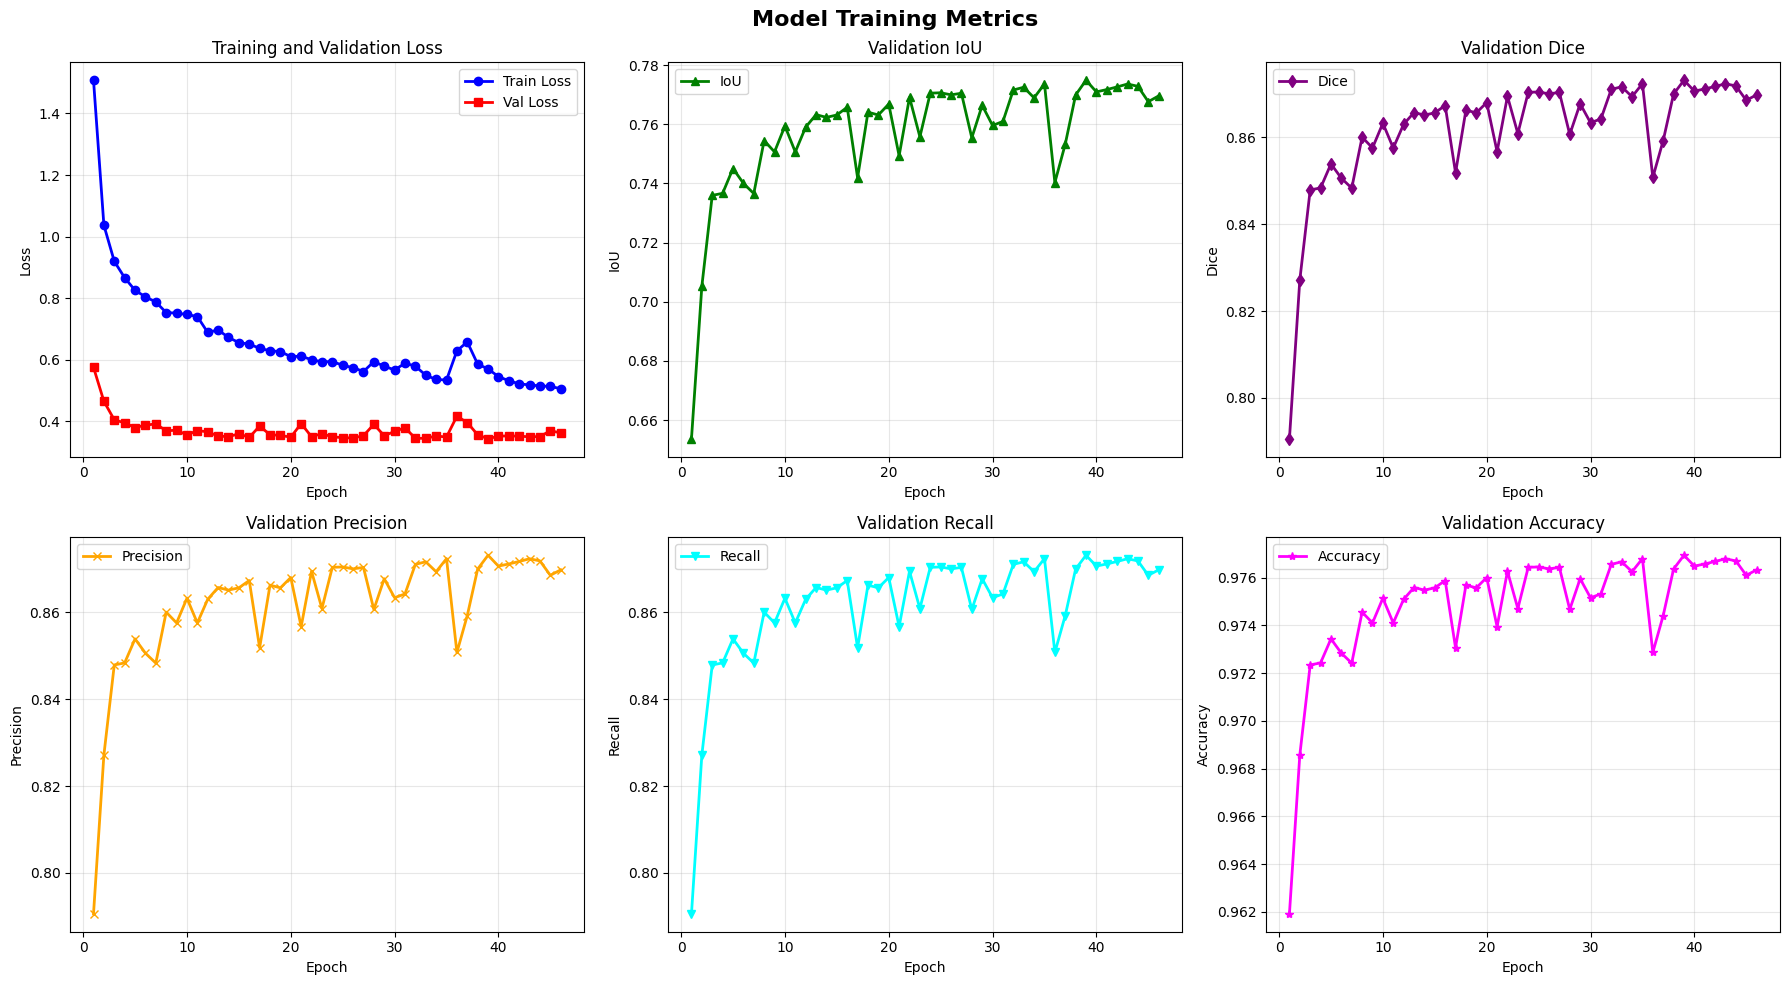

In [13]:
model = train_model(model_landcover,criterion,optimizer,train_loader, val_loader,70)

<class 'torch.Tensor'>
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


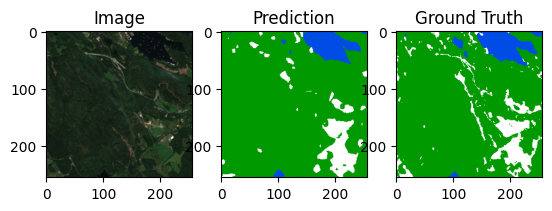

In [56]:
import random
from matplotlib.colors import ListedColormap
def test_model(model, dataset):

    colors = [
    (1, 1, 1),        # 0 = background / rest -> weiß
    (0.0, 0.6, 0.0),  # 1 = trees -> schönes grün
    (1, 1, 1),        # 2
    (1, 1, 1),        # 3
    (1, 1, 1),        # 4
    (1, 1, 1),        # 5
    (1, 1, 1),        # 6
    (1, 1, 1),        # 7
    (0.0, 0.3, 0.9),  # 8 = water -> blau
    (1, 1, 1),        # 9
    (1, 1, 1),        # 10
    ]
    cmap = ListedColormap(colors)
    
    i = random.randint(0, len(dataset)-1)
    image = torch.from_numpy(dataset["image"][i]).unsqueeze(0)
    print(type(image))
    print(image.shape)
    print(image.shape)
    mask = torch.from_numpy(dataset["mask"][i])
    with torch.no_grad():
        prediction = model(image.to(device))
    
    prediction = torch.argmax(prediction, dim=1).permute(1,2,0)
    
    img_to_plot = image.squeeze().permute(1,2,0).numpy()
    
    plt.Figure(figsize=(15,30))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(img_to_plot)

    plt.subplot(1,3,2)
    plt.title("Prediction")
    plt.imshow(prediction.cpu().numpy(), cmap=cmap, vmin=0, vmax=10)

    plt.subplot(1,3,3)
    plt.title("Ground Truth")
    plt.imshow(mask, cmap=cmap, vmin=0, vmax=10)

    plt.plot()

test_model(model_landcover, test_ds)

In [62]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_tree_change_over_years(model, images_per_year, device):
    model.eval()

    years = sorted(images_per_year.keys())
    tree_percentages = []
    predictions = {}

    # =====================
    # ESA WorldCover Farben & Labels
    # =====================
    worldcover_colors = [
        (1.0, 1.0, 1.0),  # Background
        (0.0, 0.6, 0.0),  # 10 Tree cover
        (0.7, 1.0, 0.4),  # 30 Grassland
        (1.0, 1.0, 0.5),  # 40 Cropland
        (0.8, 0.2, 0.2),  # 50 Built-up
        (0.9, 0.9, 0.9),  # 60 Bare / sparse
        (1.0, 1.0, 1.0),  # 70 Snow and ice
        (0.0, 0.3, 0.9),  # 80 Water
        (0.4, 0.8, 0.8),  # 90 Herbaceous wetland
        (0.0, 0.5, 0.0),  # 95 Mangroves
        (0.6, 0.6, 0.6),  # 100 Moss & lichen
    ]
    # Wir arbeiten intern mit Klassen 0-10, also cmap auf 0-10
    cmap = ListedColormap(worldcover_colors)

    # Labels für Legende
    class_labels = [
        "Tree cover (10)",
        "Shrubland (20)",
        "Grassland (30)",
        "Cropland (40)",
        "Built-up (50)",
        "Bare / sparse (60)",
        "Snow and ice (70)",
        "Water (80)",
        "Herbaceous wetland (90)",
        "Mangroves (95)",
        "Moss & lichen (100)"
    ]

    legend_elements = [Patch(facecolor=col, edgecolor='k', label=label) 
                       for col, label in zip(worldcover_colors, class_labels)]

    # =====================
    # Prediction pro Jahr
    # =====================
    with torch.no_grad():
        for year in years:
            img = torch.from_numpy(images_per_year[year]).float()
            resizer = transforms.Resize((256,256))
            img = transforms.ToPILImage()(img)
            img = resizer(img)
            img = transforms.ToTensor()(img)
            img = img.unsqueeze(0).to(device)
            out = model(img)
            pred = torch.argmax(out, dim=1)[0].cpu().numpy()

            predictions[year] = pred
            # Tree cover = Klasse 10 → intern 1 ?
            tree_frac = np.mean(pred == 1)  # Wenn 0 = Tree cover
            tree_percentages.append(tree_frac * 100)

    # =====================
    # Plot 1: Masken pro Jahr mit Legende
    # =====================
    fig, axes = plt.subplots(2, len(years), figsize=(4*len(years), 6))

    for i, year in enumerate(years):
        img = images_per_year[year]
        img = np.moveaxis(img, 0, -1)
        mask = predictions[year]

        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{year} – Bild")
        axes[0, i].axis("off")

        im = axes[1, i].imshow(mask, cmap=cmap, vmin=0, vmax=10)
        axes[1, i].set_title(f"{year} – Maske")
        axes[1, i].axis("off")

    # Legende einmalig rechts
    axes[1, -1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # =====================
    # Plot 2: Baumanteil über Jahre
    # =====================
    plt.figure(figsize=(6,4))
    plt.plot(years, tree_percentages, marker="o")
    plt.xlabel("Jahr")
    plt.ylabel("Baumfläche (%)")
    plt.title("Entwicklung der Baumfläche")
    plt.grid(True)
    plt.show()

    return dict(zip(years, tree_percentages))



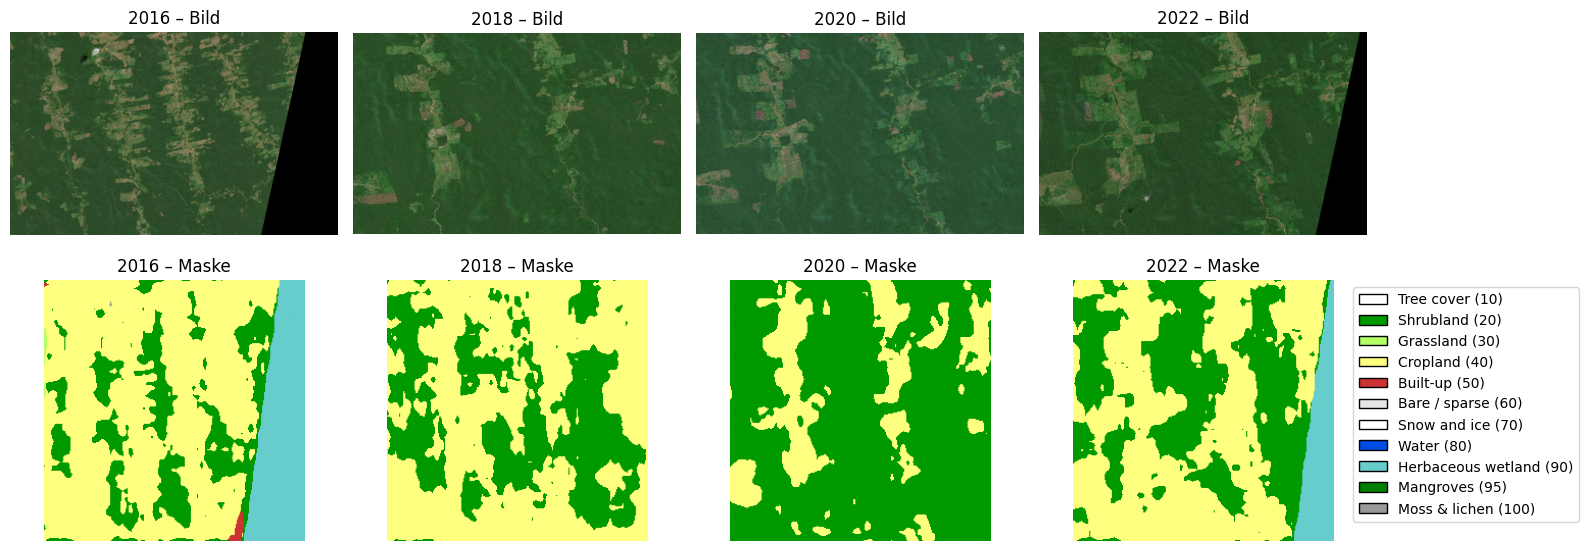

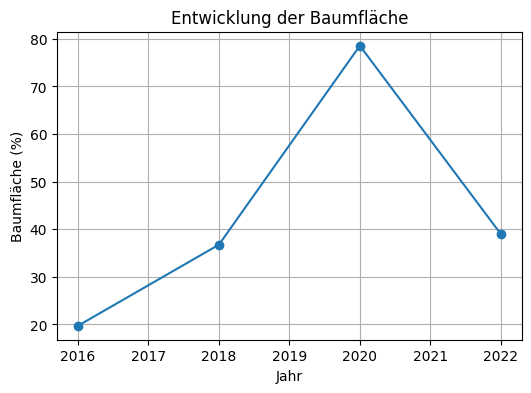

{2016: np.float64(19.73419189453125),
 2018: np.float64(36.75994873046875),
 2020: np.float64(78.5430908203125),
 2022: np.float64(39.007568359375)}

In [63]:
import rasterio
deforest_imgs_dir = "/home/lck/Schreibtisch/deforest/"
years = sorted(os.listdir(deforest_imgs_dir))
imgs_years = {}
for year in years:
    path = os.path.join(deforest_imgs_dir, year)
    deforest_imgs = sorted(os.listdir(path))
    with rasterio.open(os.path.join(path,deforest_imgs[4])) as src:
        imgs_years[int(year)] = src.read()
        

plot_tree_change_over_years(model_landcover, imgs_years, device)